# Libraries

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib
# !pip install python --upgrade
# !pip install keras tensorflow --upgrade
# !apt-get install -y git

In [ ]:
# Importing necessary libraries
import os
import zipfile
import shutil
import numpy as np
import cv2                # For computer vision tasks
import imghdr             # For determining image file types
import tensorflow as tf   # TensorFlow for deep learning

# Importing components for building convolutional neural networks
from keras.models import Sequential,load_model # Sequential model for stacking layers
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout,
    Dense,
    Flatten
)

from keras import layers, models, optimizers  # Components for neural networks


# Importing visualization and evaluation libraries
import plotly                           # For interactive plots
import plotly.graph_objects as go       # Module for graph objects in Plotly
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)                                     # Metrics for evaluation

# Importing plotting library for static plots
from matplotlib import pyplot as plt

# Importing utility functions
from sklearn.utils.class_weight import compute_class_weight  # Utility for computing class weights
from keras.callbacks import EarlyStopping                    # Callback for early stopping in model training

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from keras.applications import EfficientNetB0
from keras.applications import VGG16
from keras.applications import ResNet50


#Clone Dataset from github

In [ ]:
!git clone -b main --single-branch https://github.com/dynci22/Thesis
!rm -rf Thesis/.git
!mv Thesis/* /content/
!rm -r Thesis

Cloning into 'Thesis'...
remote: Enumerating objects: 13999, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 13999 (delta 27), reused 0 (delta 0), pack-reused 13955
Receiving objects: 100% (13999/13999), 405.04 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (13600/13600), done.


In [ ]:
base_dir = '/content'
dir_names = ['train', 'test', 'valid']
dir_list = [os.path.join(base_dir, dir_name) for dir_name in dir_names]

# **Functions Required**

## Plot Image

In [ ]:
def create_class_mapping(directory):
    """
    Create a mapping from class folder names to unique identifiers.

    Parameters:
    - directory (str): Path to the directory containing class subfolders.

    Returns:
    - dict: Mapping from class folder names to unique identifiers.
    """
    class_folders = sorted(os.listdir(directory))
    class_mapping = {folder: i for i, folder in enumerate(class_folders)}
    return class_mapping

def plot_images(tensorflow_dataset, class_mapping, num_batches=4):
    """
    Plot images from a TensorFlow dataset using Matplotlib.

    Parameters:
    - tensorflow_dataset (tf.data.Dataset): TensorFlow dataset containing images and labels.
    - class_mapping (dict): Mapping from class folder names to unique identifiers.
    - num_batches (int): Number of batches to display.
    """
    # Create subplots with the specified number of columns
    num_columns = min(num_batches, 4)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))

    # Loop through the specified number of batches
    for batch_idx, (images, labels) in enumerate(tensorflow_dataset.take(num_batches)):
        # batch size is 32, choose the first image
        img_array = images[0].numpy().astype(np.uint8)  # Convert to uint8

        # Get class index and map it to class name
        class_index = tf.argmax(labels[0]).numpy()
        class_name = next((name for name, index in class_mapping.items() if index == class_index), f"Class {class_index}")

        # Display the image with class name
        axes[batch_idx].imshow(img_array)
        axes[batch_idx].set_title(class_name)
        axes[batch_idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## create_image_dataset

In [ ]:
def create_image_dataset(directory, batch_size=32, image_size=(224, 224), shuffle=True, seed=42):
    """
    Create a TensorFlow image dataset from a given directory.

    Parameters:
    - directory (str): Path to the directory.
    - batch_size (int): Batch size for the dataset.
    - image_size (tuple): Size of the images (height, width).
    - shuffle (bool): Whether to shuffle the dataset.
    - seed (int): Seed for shuffling.

    Returns:
    - tf.data.Dataset: TensorFlow image dataset.
    """
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
        seed=seed,
        validation_split=None,
        subset=None
    )

In [ ]:
!mkdir /content/logs  # Creates a directory for storing logs

logdir = '/content/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
tensorboard_port = 6006

## Plot loss graph

In [ ]:
def plot_loss(history):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                             y=history.history['loss'],
                             mode='lines',
                             name='Training Loss',
                             line=dict(color='teal')))

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss',
                             line=dict(color='orange')))

    fig.update_layout(title='Loss',
                      xaxis=dict(title='Epochs'),
                      yaxis=dict(title='Loss'),
                      legend=dict(x=0, y=1.0),
                      showlegend=True,
                      grid=dict(rows=1, columns=1))

    fig.show()


## Plot accuracy graph

In [ ]:
def plot_accuracy(history):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)),
                             y=history.history['accuracy'],
                             mode='lines',
                             name='Training Accuracy',
                             line=dict(color='teal')))

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)),
                             y=history.history['val_accuracy'],
                             mode='lines',
                             name='Validation Accuracy',
                             line=dict(color='orange')))

    fig.update_layout(title='Accuracy',
                      xaxis=dict(title='Epochs'),
                      yaxis=dict(title='Accuracy'),
                      legend=dict(x=0, y=1.0),
                      showlegend=True,
                      grid=dict(rows=1, columns=1))  # Corrected the grid argument

    fig.show()


## Evaluation of model


In [ ]:
def get_class_names(data_dir):
    return sorted(os.listdir(data_dir))

def evaluate_test(model, modelName, test, test_dir):
    print(f"Model: {modelName} / Test: {test_dir}")
    print()

    # Get class names from subfolder names
    class_names = get_class_names(test_dir)

    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Loop through the test data to get true and predicted labels
    for batch, labels in test:
        predicted_data = model.predict(batch)
        yhat_classes = np.argmax(predicted_data, axis=1)

        true_labels.extend(np.argmax(labels, axis=1))
        predicted_labels.extend(yhat_classes)

    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate precision, recall, and accuracy
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Print precision, recall, and accuracy
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    fig = go.Figure(data=[go.Heatmap(z=conf_matrix, x=class_names, y=class_names)])
    fig.update_layout(
        title=f"Confusion Matrix {modelName} applied on {test_dir}",
        xaxis_title="Predicted",
        yaxis_title="True",
        autosize=False,
        width=800,
        height=800
    )
    fig.show()

    # Print classification report with precision, recall, f1-score, and support
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print()
    print(f"Classification Report for {modelName} applied on {test_dir}:")
    print(class_report)

    # Print summary
    print()
    loss, accuracy = model.evaluate(test)
    print(f"Test Loss for {modelName} applied on {test_dir}: {loss:.4f}")
    print(f"Test Accuracy for {modelName} applied on {test_dir}: {accuracy * 100:.2f}%")
    print("-----------------------------------------------------------------------")
    print()

# GPU Check for Colab

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Image preprocessing

## Removing Dodgy Images

In [ ]:
image_extensions = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
def filter_images(dir_list, image_exts):
    for directory in dir_list:
        for image_class in os.listdir(directory):
            for image in os.listdir(os.path.join(directory, image_class)):
                image_path = os.path.join(directory, image_class, image)
                try:
                    img = cv2.imread(image_path)
                    image_type = imghdr.what(image_path)

                    if image_type not in image_exts:
                        print(f'Image not in extension list: {image_path}')
                        os.remove(image_path)

                except Exception as e:
                    print(f'Issue with image: {image_path}')

filter_images(dir_list, image_extensions)

## Count Images

In [ ]:
def count_images_in_dir(directory, image_extensions):
    """
    Count the number of images in a given directory with specified image extensions.

    Parameters:
    - directory (str): Path to the directory.
    - image_extensions (list): List of allowed image file extensions.

    Returns:
    - int: Count of images in the directory.
    """
    count = 0
    for root, dirs, files in os.walk(directory):
        count += sum(1 for filename in files if any(filename.lower().endswith(ext) for ext in image_extensions))
    return count

def generate_directory_stats(dir_list, image_extensions):
    """
    Generate statistics for each directory in the list.

    Parameters:
    - dir_list (list): List of directory paths.
    - image_extensions (list): List of allowed image file extensions.

    Returns:
    - tuple: Total folder count, total image count, folder names, subfolder counts, image counts.
    """
    folder_names = []
    subfolder_counts = []
    image_counts = []

    total_folder_count = 0
    total_image_count = 0

    for dir_path in dir_list:
        subfolder_count = len(next(os.walk(dir_path))[1])
        current_image_count = count_images_in_dir(dir_path, image_extensions)

        folder_names.append(dir_path)
        subfolder_counts.append(subfolder_count)
        image_counts.append(current_image_count)

        total_folder_count += 1 + subfolder_count
        total_image_count += current_image_count

    return total_folder_count, total_image_count, folder_names, subfolder_counts, image_counts

def display_directory_stats(dir_list, image_extensions):
    """
    Display directory statistics using Plotly.

    Parameters:
    - dir_list (list): List of directory paths.
    - image_extensions (list): List of allowed image file extensions.

    Returns:
    - tuple: Total folder count, total image count.
    """
    total_folder_count, total_image_count, folder_names, subfolder_counts, image_counts = generate_directory_stats(dir_list, image_extensions)

    table_data = [folder_names, subfolder_counts, image_counts]

    header = ["Folder Name", "Subfolders", "Images"]
    table = go.Figure(data=[go.Table(header=dict(values=header),
                                     cells=dict(values=table_data))
                           ])

    table.show()

    return total_folder_count, total_image_count


# Exploratory Data Analysis

## Load Data

In [ ]:
total_folders, total_images = display_directory_stats(dir_list, image_extensions)
print(f"Total folders: {total_folders}, Total images: {total_images}")

Total folders: 303, Total images: 13594


In [ ]:
data_train = create_image_dataset(dir_list[0])
data_test = create_image_dataset(dir_list[1])
data_valid = create_image_dataset(dir_list[2])


Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


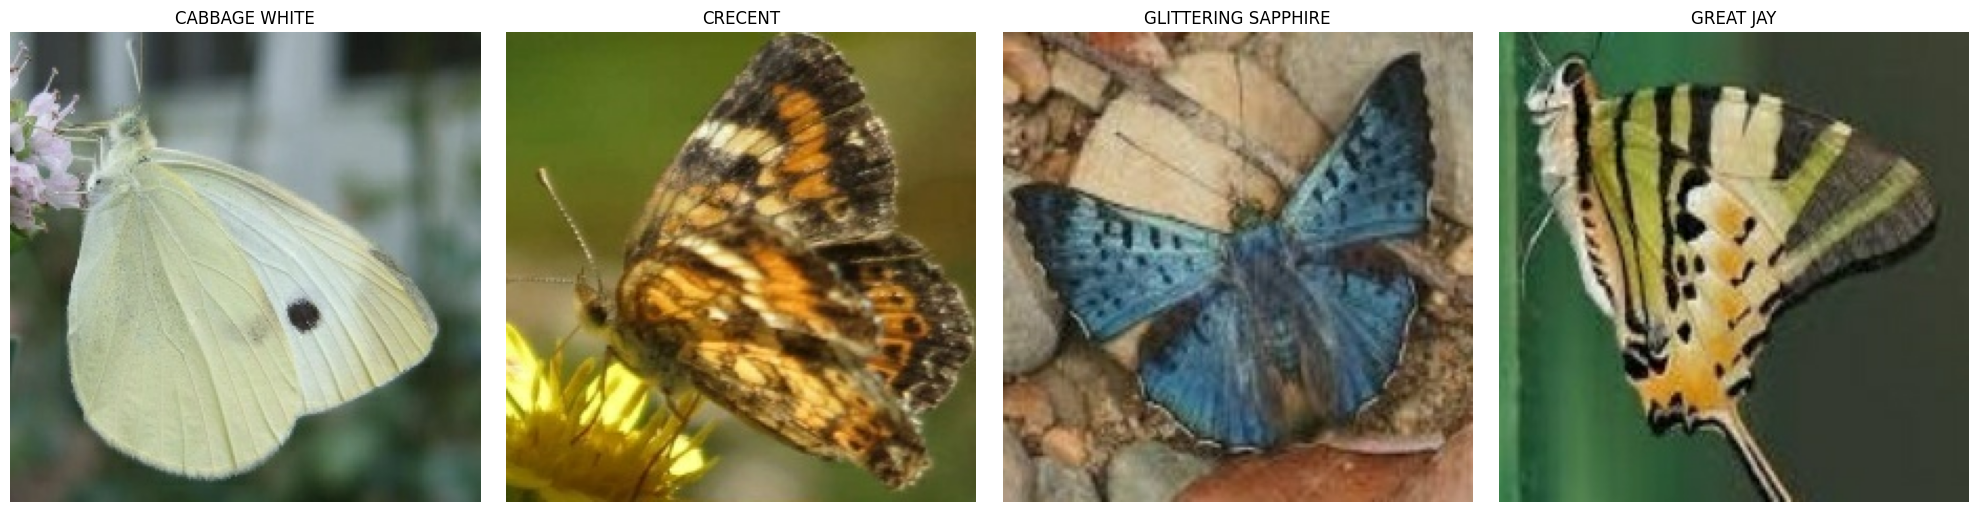

In [ ]:
train_directory = "/content/train"
class_mapping = create_class_mapping(train_directory)
plot_images(data_train,class_mapping)

## Visualization of class balance

In [ ]:
# Initialized a dictionary to store class names and their respective image counts
class_image_counts = {}
base_dir = "/content/train"
# Iterated through the subdirectories (classes) in the base directory
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)

    # Checked if it was a directory
    if os.path.isdir(class_dir):
        # Listed all files in the directory with a specific image file extension (e.g., .jpg, .jpeg, .png, .gif)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

        # Counted the number of image files in the directory
        image_count = len(image_files)

        # Stored the class name and image count in the dictionary
        class_image_counts[class_name] = image_count

# Created a DataFrame from the dictionary
df = pd.DataFrame(list(class_image_counts.items()), columns=['Class Name', 'Image Count'])
df = df.sort_values(by='Class Name', ascending=True)
# Added a serial number column
df['Serial No'] = range(1, len(df) + 1)

# Sorted the DataFrame by Serial No in ascending order
df = df.sort_values(by='Serial No', ascending=True)


# Calculated the mean of the "Image Count" column
mean_image_count = df['Image Count'].mean()

# Created a table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=['Sr. No', 'Class Name', 'Image Count'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df['Serial No'], df['Class Name'], df['Image Count']],
               fill_color='lavender',
               align=['center', 'left', 'center']),  # Adjusted alignment
    columnwidth=[0.10, 0.15, 0.10]  # Adjusted column widths
)
])

# Customized the table layout
fig.update_layout(
    title='Image Counts by Class',
    width = 700, height = 600
)

# Showed the table
fig.show()

# Created a bar chart using Plotly Express
fig = px.bar(df, x='Class Name', y='Image Count', title='Image Counts by Butterfly Species',
             color='Image Count',  # Color grading based on image count
             color_continuous_scale='viridis')  # Using a color scale for better visualization

# Added a mean line to the bar chart
fig.add_hline(y=mean_image_count, line_dash="dot", line_color="red", annotation_text=f'Mean: {mean_image_count:.2f}', annotation_position="top right")

# Customized the chart layout
fig.update_layout(xaxis_title='Butterfly Species', yaxis_title='Image Count')
fig.update_xaxes(categoryorder='total descending')  # Sorted bars by total image count in descending order

# Showed the chart
fig.show()


# Build Deep Learning Model

# ButterflyNet Model

In [ ]:
# Creating a Sequential model for a Convolutional Neural Network (CNN) for image classification.

# The model consists of multiple convolutional layers, each followed by batch normalization,
# max pooling, and dropout for feature extraction and regularization.

# Convolutional layers:
# - The first convolutional layer extracts basic features from the input image.
# - Subsequent convolutional layers capture increasingly complex patterns.

# Batch Normalization:
# - Normalizes the activations of the layers, stabilizing and accelerating training.

# Max Pooling:
# - Reduces spatial dimensions, downsampling feature maps and retaining important information.

# Dropout:
# - Regularization technique that randomly drops a fraction of input units during training,
#   preventing overfitting and promoting more robust feature learning.

ButterflyNet = models.Sequential()

# Convolutional layers with batch normalization and dropout
ButterflyNet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Extracts basic features
ButterflyNet.add(layers.BatchNormalization())  # Stabilizes and accelerates training
ButterflyNet.add(layers.MaxPooling2D((2, 2)))  # Downsampling, retains important information
ButterflyNet.add(layers.Dropout(0.25))  # Prevents overfitting

ButterflyNet.add(layers.Conv2D(64, (3, 3), activation='relu'))
ButterflyNet.add(layers.BatchNormalization())
ButterflyNet.add(layers.MaxPooling2D((2, 2)))
ButterflyNet.add(layers.Dropout(0.25))

ButterflyNet.add(layers.Conv2D(128, (3, 3), activation='relu'))
ButterflyNet.add(layers.BatchNormalization())
ButterflyNet.add(layers.MaxPooling2D((2, 2)))
ButterflyNet.add(layers.Dropout(0.25))

# Additional Convolutional layers with batch normalization and dropout
ButterflyNet.add(layers.Conv2D(256, (3, 3), activation='relu'))
ButterflyNet.add(layers.BatchNormalization())
ButterflyNet.add(layers.MaxPooling2D((2, 2)))
ButterflyNet.add(layers.Dropout(0.25))

ButterflyNet.add(layers.Conv2D(512, (3, 3), activation='relu'))
ButterflyNet.add(layers.BatchNormalization())
ButterflyNet.add(layers.MaxPooling2D((2, 2)))
ButterflyNet.add(layers.Dropout(0.25))

# Flatten layer
ButterflyNet.add(layers.Flatten())  # Converts 3D feature maps to a 1D vector

# Dense layers with dropout
ButterflyNet.add(layers.Dense(512, activation='relu'))  # Fully connected layer
ButterflyNet.add(layers.BatchNormalization())
ButterflyNet.add(layers.Dropout(0.5))  # Regularization to prevent overfitting

ButterflyNet.add(layers.Dense(256, activation='relu'))
ButterflyNet.add(layers.BatchNormalization())
ButterflyNet.add(layers.Dropout(0.5))

ButterflyNet.add(layers.Dense(100, activation='softmax'))  # 100 classes

# Compile the ButterflyNet with a learning rate scheduler
initial_learning_rate = 0.001
adam_optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

ButterflyNet.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print ButterflyNet summary
ButterflyNet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

## Train

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the ButterflyNet with early stopping
history_ButterflyNet = ButterflyNet.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping])
ButterflyNet.save("ButterflyNet_Model.keras")

Epoch 1/50
394/394 [==============================] - 75s 151ms/step - loss: 4.1618 - accuracy: 0.1074 - val_loss: 3.0954 - val_accuracy: 0.2320
Epoch 2/50
344/394 [=========================>....] - ETA: 7s - loss: 2.8543 - accuracy: 0.2781

## Plot Performance

In [ ]:
plot_loss(history_ButterflyNet)
plot_accuracy(history_ButterflyNet)

## Evaluate

In [ ]:
evaluate_test(ButterflyNet, "ButterflyNet", data_test, dir_list[1])

# EfficientNetB0


In [ ]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

custom_model = models.Sequential()

# Add the pre-trained model
custom_model.add(base_model)


custom_model.add(layers.Flatten())
custom_model.add(layers.Dense(256, activation='relu'))
custom_model.add(layers.BatchNormalization())
custom_model.add(layers.Dropout(0.25))
custom_model.add(layers.Dense(100, activation='softmax'))

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
adam_optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

custom_model.compile(optimizer=adam_optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print model summary
custom_model.summary()


16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16056576  
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                       

## Train

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_custom_model = custom_model.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping])
custom_model.save("custom_model_EfficientNetB0.keras")

Epoch 1/50
394/394 [==============================] - 42s 84ms/step - loss: 1.2140 - accuracy: 0.7247 - val_loss: 0.3334 - val_accuracy: 0.9240
Epoch 2/50
394/394 [==============================] - 31s 78ms/step - loss: 0.1760 - accuracy: 0.9588 - val_loss: 0.2844 - val_accuracy: 0.9120
Epoch 3/50
394/394 [==============================] - 32s 81ms/step - loss: 0.0720 - accuracy: 0.9855 - val_loss: 0.2882 - val_accuracy: 0.9180
Epoch 4/50
394/394 [==============================] - 32s 81ms/step - loss: 0.0463 - accuracy: 0.9905 - val_loss: 0.2486 - val_accuracy: 0.9380
Epoch 5/50
394/394 [==============================] - 31s 77ms/step - loss: 0.0325 - accuracy: 0.9933 - val_loss: 0.2790 - val_accuracy: 0.9260
Epoch 6/50
394/394 [==============================] - 30s 77ms/step - loss: 0.0364 - accuracy: 0.9914 - val_loss: 0.3260 - val_accuracy: 0.9260
Epoch 7/50
394/394 [==============================] - 30s 77ms/step - loss: 0.0435 - accuracy: 0.9915 - val_loss: 0.3532 - val_accuracy:

## Evaluate

In [ ]:
evaluate_test(custom_model, "custom_model_EfficientNetB0", data_test, dir_list[1])

Model: custom_model_EfficientNetB0 / Test: /content/test

1/1 [==============================] - 2s 2s/step
Precision: 94.63%
Recall: 94.00%
Accuracy: 94.00%



Classification Report for custom_model_EfficientNetB0 applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       1.00      0.80      0.89         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       0.83      1.00      0.91         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00 

## Plot Performance

In [ ]:
plot_loss(history_custom_model)
plot_accuracy(history_custom_model)

# VGG-16

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable = False

vgg_custom_model = models.Sequential()
vgg_custom_model.add(vgg_model)
vgg_custom_model.add(layers.Flatten())
vgg_custom_model.add(layers.Dense(256, activation='relu'))
vgg_custom_model.add(layers.BatchNormalization())
vgg_custom_model.add(layers.Dropout(0.5))
vgg_custom_model.add(layers.Dense(100, activation='softmax'))

vgg_custom_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

vgg_custom_model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_8 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               

## Train

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history_vgg_custom_model = vgg_custom_model.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping])
vgg_custom_model.save("vgg_custom_model.keras")

Epoch 1/50
394/394 [==============================] - 69s 162ms/step - loss: 1.3208 - accuracy: 0.7086 - val_loss: 0.4155 - val_accuracy: 0.8900
Epoch 2/50
394/394 [==============================] - 57s 145ms/step - loss: 0.1311 - accuracy: 0.9793 - val_loss: 0.3127 - val_accuracy: 0.9100
Epoch 3/50
394/394 [==============================] - 58s 146ms/step - loss: 0.0371 - accuracy: 0.9952 - val_loss: 0.2838 - val_accuracy: 0.9240
Epoch 4/50
394/394 [==============================] - 58s 147ms/step - loss: 0.0198 - accuracy: 0.9977 - val_loss: 0.2754 - val_accuracy: 0.9260
Epoch 5/50
394/394 [==============================] - 57s 144ms/step - loss: 0.0159 - accuracy: 0.9984 - val_loss: 0.2739 - val_accuracy: 0.9280
Epoch 6/50
394/394 [==============================] - 57s 144ms/step - loss: 0.0129 - accuracy: 0.9984 - val_loss: 0.2847 - val_accuracy: 0.9300
Epoch 7/50
394/394 [==============================] - 57s 144ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.3059 - val_ac

## Evaluate

In [ ]:
evaluate_test(vgg_custom_model, "vgg_custom_model", data_test, dir_list[1])

Model: vgg_custom_model / Test: /content/test

1/1 [==============================] - 0s 165ms/step
Precision: 95.35%
Recall: 94.60%
Accuracy: 94.60%



Classification Report for vgg_custom_model applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.71      1.00      0.83         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00  

## Plot Performance

In [ ]:
plot_loss(history_vgg_custom_model)
plot_accuracy(history_vgg_custom_model)

# ResNet50

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False

resnet_custom_model = models.Sequential()
resnet_custom_model.add(resnet_model)
resnet_custom_model.add(layers.Flatten())
resnet_custom_model.add(layers.Dense(256, activation='relu'))
resnet_custom_model.add(layers.BatchNormalization())
resnet_custom_model.add(layers.Dropout(0.5))
resnet_custom_model.add(layers.Dense(100, activation='softmax'))

resnet_custom_model.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

resnet_custom_model.summary()


94765736/94765736 [==============================] - 6s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               

## Train

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history_resnet_custom_model = resnet_custom_model.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping])
resnet_custom_model.save("resnet_custom_model.keras")

Epoch 1/50
394/394 [==============================] - 54s 123ms/step - loss: 1.1626 - accuracy: 0.7418 - val_loss: 0.3663 - val_accuracy: 0.9180
Epoch 2/50
394/394 [==============================] - 45s 115ms/step - loss: 0.0919 - accuracy: 0.9845 - val_loss: 0.3317 - val_accuracy: 0.9060
Epoch 3/50
394/394 [==============================] - 47s 119ms/step - loss: 0.0258 - accuracy: 0.9962 - val_loss: 0.2849 - val_accuracy: 0.9360
Epoch 4/50
394/394 [==============================] - 45s 115ms/step - loss: 0.0100 - accuracy: 0.9992 - val_loss: 0.2626 - val_accuracy: 0.9380
Epoch 5/50
394/394 [==============================] - 45s 115ms/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.2777 - val_accuracy: 0.9340
Epoch 6/50
394/394 [==============================] - 47s 118ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.2889 - val_accuracy: 0.9360


## Plot Performance

In [ ]:
plot_loss(history_resnet_custom_model)
plot_accuracy(history_resnet_custom_model)

## Evaluate

In [ ]:
evaluate_test(resnet_custom_model, "resnet_custom_model", data_test, dir_list[1])

Model: resnet_custom_model / Test: /content/test

1/1 [==============================] - 1s 924ms/step
Precision: 96.06%
Recall: 95.60%
Accuracy: 95.60%



Classification Report for resnet_custom_model applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       0.83      1.00      0.91         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.83      1.00      0.91         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80      0.8

# Comparision of model

| Model                  | Test Loss | Test Accuracy |
|------------------------|-----------|---------------|
| EfficientNetB0         | 0.1767    | 95.18%        |
| ResNet50               | 0.2555    | 93.40%        |
| VGG Custom Model       | 0.3015    | 92.00%        |
| ButterflyNet Model     | 0.4619    | 88.00%        |


# Streamlit

In [1]:
%%writefile app.py
# Import statements
import streamlit as st
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd
from datetime import datetime
import os

def set_bg_from_path(image_path):
    '''
    A function to unpack an image from a local path and set it as background.

    Parameters
    ----------
    image_path : str
        The local path or URL to the image file.
    '''
    st.markdown(
        f"""
        <style>
        .stApp {{
            background: url("{image_path}");
            background-size: cover;
        }}
        </style>
        <style>
        [data-testid="stHeader"] {{
            background: url("{image_path}");
            background-size: cover;
            position: relative;
            z-index: 1;
        }}
        [data-testid="stDecoration"] {{
            position: relative;
            z-index: 2;
        }}
        [data-testid="stToolbar"] {{
            position: relative;
            z-index: 2;
        }}
        </style>
        """,
        unsafe_allow_html=True
    )

# Streamlit App
st.set_page_config(page_title="Butterfly World", page_icon="🦋", layout="wide")

# Include the CSS animation library
st.markdown('<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/animate.css/4.1.1/animate.min.css">', unsafe_allow_html=True)

# Replace with the actual path or URL to your image file
image_path = "https://raw.githubusercontent.com/dynci22/Thesis/colab/butterfliesBackPicture.jpg"

# Set the background using the function
set_bg_from_path(image_path)

# Added a welcoming message with formatted text and a slowed-down animation
welcome_text = st.markdown("<div style='text-align: left; padding: 20px;'><h1 style='color: #e8209c; display: inline-block;' class='animate__animated animate__fadeInLeft animate__slower'>Hello, Welcome</h1></div>", unsafe_allow_html=True)
subtitle_text = st.markdown("<div style='text-align: left; padding: 20px;'><h2 style='color: #4CAF50; display: inline-block;' class='animate__animated animate__fadeInLeft animate__slower'>to the</h2></div>", unsafe_allow_html=True)
butterfly_text = st.markdown("<div style='text-align: left; padding: 20px;'><h1 style='color: #e8209c; display: inline-block;' class='animate__animated animate__fadeInLeft animate__slower'>Butterfly and Moth</h1></div>", unsafe_allow_html=True)
world_text = st.markdown("<div style='text-align: left; padding: 20px;'><h2 style='color: #4CAF50; display: inline-block;' class='animate__animated animate__fadeInLeft animate__slower'>World</h2></div>", unsafe_allow_html=True)

#########################*********************Page 2*****************************************
def create_class_mapping(directory):
    """
    Create a mapping from class folder names to unique identifiers.

    Parameters:
    - directory (str): Path to the directory containing class subfolders.

    Returns:
    - dict: Mapping from class folder names to unique identifiers.
    """
    class_folders = sorted(os.listdir(directory))
    class_mapping = {folder: i for i, folder in enumerate(class_folders)}
    return class_mapping
def run_image_classification(model_path):
    """
    Run image classification with a given model.

    Parameters:
        model_path (str): Path to the trained model file.

    Returns:
        None
    """
    # Load your trained model
    model = tf.keras.models.load_model(model_path)

    # Function to preprocess the image
    def preprocess_img(img_path):
      # Load image and check its size
      img = image.load_img(img_path)

      # Check if the image is already of size 224x224
      if img.size == (224, 224):
          # No changes needed, return the image as it is
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis=0)
          img_array = preprocess_input(img_array)
          return img_array
      else:
          # Resize the image to 224x224 and perform preprocessing
          img = image.load_img(img_path, target_size=(224, 224))
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis=0)
          img_array = preprocess_input(img_array)
          return img_array


    # Streamlit App
    st.markdown(
        """
        <div style='
            background-color: #f0f0f0;
            padding: 20px;
            border-radius: 10px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            animation: fadeIn 1s ease-out;
        '>
            <h1 style='font-size:32px; color:#3366ff; text-align:center;'>Discover Butterfly or Moth Species</h1>
            <p style='font-size:18px; color:black; text-align:center;'>
                Upload your favorite butterfly/Moth picture and uncover its enchanting species!
            </p>
        </div>

        <style>
            @keyframes fadeIn {
                from { opacity: 0; }
                to { opacity: 1; }
            }
        </style>
        """,
        unsafe_allow_html=True
    )

    # Choose an image
    uploaded_file = st.file_uploader("Choose an image...", type="jpg")

    if uploaded_file is not None:
        # Display the uploaded image
        st.image(uploaded_file, caption='Uploaded Image.', use_column_width=True)

        # Preprocess the image
        img_array = preprocess_img(uploaded_file)

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = tf.argmax(predictions, axis=1).numpy()
        confidence = predictions[0, predicted_class]

        # Load class mapping
        train_directory = "/content/test"
        class_mapping = create_class_mapping(train_directory)
        class_name = next((name for name, index in class_mapping.items() if index == predicted_class), f"Class {predicted_class[0]}")

        # Styling for the subheader
        subheader_style = """
            background-color: #4682b4;  /* SteelBlue color */
            color: #ffffff;  /* White color */
        """
        # Styling for the results container
        result_container_style = """
            background-color: #f8f8f8;
            padding: 20px;
            border-radius: 10px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            animation: fadeIn 1s ease-out;
        """

        # Styling for the species name
        species_name_style = """
            font-size: 24px;
            color: #2e8b57;  /* SeaGreen color */
            margin-bottom: 10px;
        """

        # Styling for the confidence
        confidence_style = """
            font-size: 18px;
            color: #4169e1;  /* RoyalBlue color */
        """

        # Apply the styles
        st.markdown(
            f"""
            <div style='{result_container_style}'>
                 <h2 style='{subheader_style}'>🦋 Your Butterfly/Moth Species Prediction 🌿</h2>
                <h3 style='{species_name_style}'>{class_name}</h3>
                <p style='{confidence_style}'>Confidence of Model: {confidence[0]:.2%}</p>
            </div>
            """,
            unsafe_allow_html=True
        )



    else:
        st.warning("Please upload an image to continue.")

###################************************end***********************************************

if 'Page2' not in st.session_state:
    st.session_state.Page2 = False
if 'reset' not in st.session_state:
    st.session_state.reset = False
if 'page1' not in st.session_state:
    st.session_state.page1 = True
if 'remove_page1_data' not in st.session_state:
    st.session_state.remove_page1_data = False

def btn_a_callback():
    st.session_state.Page2=True
    st.session_state.remove_page1_data = True
    st.session_state.reset=False
    st.session_state.page1 = False

def btn_b_callback():
    st.session_state.Page2=False
    st.session_state.reset=True
    st.session_state.page1 = True
    st.session_state.remove_page1_data = False

if st.session_state.page1:
  button_a = st.button('Let\'s GO', on_click=btn_a_callback)


if st.session_state.Page2:
    button_b = st.button('Exit', on_click=btn_b_callback)

if st.session_state.remove_page1_data:
  welcome_text.empty()
  subtitle_text.empty()
  butterfly_text.empty()
  world_text.empty()
  # User option to choose the model
  model_options = {
    "ButterflyNet Model": "/content/ButterflyNet_Model.keras",
    "EfficientNetB0 Model": "/content/custom_model_EfficientNetB0.keras",
    "ResNet50 Model": "/content/resnet_custom_model.keras",
    "VGG16 Model": "/content/vgg_custom_model.keras",
  }
  selected_model = st.selectbox("Select Model", list(model_options.keys()))
  run_image_classification(model_options[selected_model])



Writing app.py


## WebPage

In [ ]:
!pip install streamlit -q
!streamlit run app.py & npx localtunnel --port 8501

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.168.34:8501

npx: installed 22 in 4.743s
your url is: https://smart-jars-march.loca.lt
  Stopping...
^C
